In [1]:
import itertools
import numpy as np
import os
import seaborn as sns
from tqdm import tqdm
from dataclasses import asdict, dataclass, field
import vsketch
import shapely.geometry as sg
from shapely.geometry import box, MultiLineString, Point, MultiPoint, Polygon, MultiPolygon, LineString
import shapely.affinity as sa
import shapely.ops as so
import matplotlib.pyplot as plt
import pandas as pd

import vpype_cli
from typing import List, Generic
from genpen import genpen as gp, utils as utils
from scipy import stats as ss
import geopandas
from shapely.errors import TopologicalError
import functools
%load_ext autoreload
%autoreload 2

# Try 7

In [2]:
paper_size = '7x5 inches'
border:float=10
paper = utils.Paper(paper_size)

drawbox = paper.get_drawbox(border)
buffer_style = 2

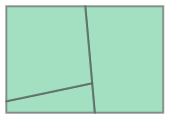

In [3]:
new, old = gp.split_poly(drawbox, gp.random_line_subdivide(drawbox, x0=0.87, x1=0.35))

bg_polys = [new] + gp.split_poly(old, gp.random_line_subdivide(old, x0=0.03, x1=0.69))

bg_right, bg_mid, bg_left = bg_polys
MultiPolygon(bg_polys)

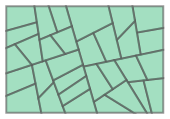

In [4]:
xgen = ss.uniform(loc=0.55, scale=0.1).rvs
split_func = functools.partial(gp.split_along_longest_side_of_min_rectangle, xgen=xgen)
splits = gp.recursive_split_frac_buffer(
    drawbox, 
    split_func=split_func,
    p_continue=0.99, 
    depth=0, 
    depth_limit=4,
    buffer_frac=-0.0
)

bps = MultiPolygon([p for p in splits])
bps

In [5]:
bg_bps_left = [so.unary_union([bp for bp in bps if bp.within(bg_left)]).buffer(0.1)]
bg_bps_right = [so.unary_union([bp for bp in bps if bp.within(bg_right)]).buffer(0.1)]

In [6]:
bg_bps_left = [bg_left]
bg_bps_right = [bg_right]
brush_left = [bg_left]

In [7]:
bg_layers = []
for bg_bps in [bg_bps_left, bg_bps_right, brush_left]:
    fills = []
    for p in bg_bps:
        xjitter_func = 0
        yjitter_func = ss.norm(loc=0, scale=np.random.uniform(0.2, 1.)).rvs
        bhf = gp.BezierHatchFill(
            spacing=np.random.uniform(0.2, 0.5),
            degrees=np.random.uniform(10, 40),
            poly_to_fill=p, 
            xjitter_func=xjitter_func, 
            yjitter_func=yjitter_func,
            fill_inscribe_buffer=1.4,
            n_nodes_per_line=15,
            n_eval_points=50,
        )
        fills.append(bhf.p)

    fills = [f for f in fills if f.length > 0]
    layer = gp.merge_LineStrings(fills)
    bg_layers.append(layer)

In [ ]:
sk = vsketch.Vsketch()
sk.size(paper.page_format_mm)
sk.scale('1mm')
sk.penWidth('0.3mm')
for i, layer in enumerate(bg_layers):
    sk.stroke(i+1)
    sk.geometry(layer)

sk.penWidth('0.3')
for tolerance in [0.3, 0.6, 1.2]:
    sk.vpype(f'linemerge --tolerance {tolerance}mm')
sk.vpype('linesimplify --tolerance 0.1 linesort')
sk.display()

In [ ]:
# init
rcp = gp.RecursiveCirclePacker(
    drawbox, 
    rad_seq_start=0.6,
    rad_seq_end=0.08,
    min_allowed_rad=3,
    n_rads=10,
)
rcp.run(1)

In [ ]:
rcp.rad_seq_start=0.6
rcp.rad_seq_end=0.08
rcp.n_rads=80
rcp.run(10, progress_bar=True)
rcp.unfilled_circles

## lattice 1

In [ ]:
trcp = gp.RecursiveCirclePacker(drawbox.buffer(20), rad_seq_start=0.13,
    rad_seq_end=0.13, min_allowed_rad=2, n_rads=10, )
trcp.run(1)
trcp.min_allowed_rad=5
trcp.rad_seq_start=0.29
trcp.rad_seq_end=0.18
trcp.run(3)

length_filter_gen = ss.uniform(96, 185).rvs
buffer_size_gen = ss.uniform(1.1, 2.).rvs
tri_vertices = MultiPoint([c.centroid for c in trcp.unfilled_circles])
trils = MultiLineString(so.triangulate(tri_vertices, edges=True))

filt_trils = MultiLineString([l for l in trils if l.length<length_filter_gen()])
tris = [f.buffer(buffer_size_gen(), cap_style=2, join_style=3) for f in filt_trils]
tris = so.unary_union(tris)
tris

In [ ]:
occluded_tris = tris.intersection(rcp.unfilled_circles).buffer(-1e-6)

In [ ]:
stp = gp.ScaleTransPrms(d_buffer=-0.18,angles=-45,)
stp.d_buffers += np.random.uniform(-0.03, 0.03, size=stp.d_buffers.shape)

In [ ]:
fills = []
for p in occluded_tris:
    P = gp.Poly(p)
    P.fill_scale_trans(**stp.prms)
    fills.append(P.fill)

In [ ]:
layer1 = gp.merge_LineStrings(fills)

In [ ]:
all_polys = occluded_tris

## lattice 2

In [ ]:
trcp = gp.RecursiveCirclePacker(drawbox.buffer(20), rad_seq_start=0.16,
    rad_seq_end=0.16, min_allowed_rad=2, n_rads=10, )
trcp.run(1)
trcp.min_allowed_rad=5
trcp.rad_seq_start=0.3
trcp.rad_seq_end=0.3
trcp.run(4)

length_filter_gen = ss.uniform(96, 185).rvs
buffer_size_gen = ss.uniform(1.1, 1.7).rvs
tri_vertices = MultiPoint([c.centroid for c in trcp.unfilled_circles])
trils = MultiLineString(so.triangulate(tri_vertices, edges=True))

filt_trils = MultiLineString([l for l in trils if l.length<length_filter_gen()])
tris = [f.buffer(buffer_size_gen(), cap_style=2, join_style=3) for f in filt_trils]
tris = so.unary_union(tris)
tris

In [ ]:
int_tris = tris.intersection(rcp.unfilled_circles)

In [ ]:
occluded_tris = gp.robust_difference(int_tris, all_polys, buffer_distance=-1e-6)

In [ ]:
stp = gp.ScaleTransPrms(d_buffer=-0.28,angles=-45,)
stp.d_buffers += np.random.uniform(-0.03, 0.03, size=stp.d_buffers.shape)

In [ ]:
fills = []
for p in occluded_tris:
    P = gp.Poly(p)
    P.fill_scale_trans(**stp.prms)
    fills.append(P.fill)

In [ ]:
layer2 = gp.merge_LineStrings(fills)

In [ ]:
all_polys = so.unary_union([all_polys, occluded_tris]).buffer(-1e-6)

## lattice3

In [ ]:
trcp = gp.RecursiveCirclePacker(drawbox.buffer(10), rad_seq_start=0.15,
    rad_seq_end=0.15, min_allowed_rad=2, n_rads=10, )
trcp.run(1)
trcp.min_allowed_rad=5
trcp.rad_seq_start=0.2
trcp.rad_seq_end=0.2
trcp.run(4)

In [ ]:
length_filter_gen = ss.uniform(96, 185).rvs
buffer_size_gen = ss.uniform(0.8, 1.4).rvs
tri_vertices = MultiPoint([c.centroid for c in trcp.unfilled_circles])
trils = MultiLineString(so.triangulate(tri_vertices, edges=True))

filt_trils = MultiLineString([l for l in trils if l.length<length_filter_gen()])
tris = [f.buffer(buffer_size_gen(), cap_style=2, join_style=3) for f in filt_trils]
tris = so.unary_union(tris)

In [ ]:
int_tris = tris.intersection(rcp.unfilled_circles)
occluded_tris = gp.robust_difference(int_tris, all_polys, buffer_distance=-1e-6)

In [ ]:
stp = gp.ScaleTransPrms(d_buffer=-0.38,angles=-45,)
stp.d_buffers += np.random.uniform(-0.03, 0.03, size=stp.d_buffers.shape)

In [ ]:
fills = []
for p in occluded_tris:
    P = gp.Poly(p)
    P.fill_scale_trans(**stp.prms)
    fills.append(P.fill)

In [ ]:
layer3 = gp.merge_LineStrings(fills)

In [ ]:
all_polys = gp.merge_Polygons([all_polys, occluded_tris])

In [ ]:

sk.stroke(4)
sk.geometry(layer1)
sk.stroke(5)
sk.geometry(layer2)
sk.stroke(6)
sk.geometry(layer3)
sk.display(color_mode='layer')

In [ ]:
savepath = '/mnt/c/code/side/plotter_images/oned_outputs/0284_cpack_beams.svg'

sk.save(savepath)

vpype_commands = 'reloop linesimplify --tolerance 0.1mm linemerge --tolerance 0.1mm linesort'
vpype_str = f'vpype read -q 0.05mm {savepath} {vpype_commands} write {savepath}'

os.system(vpype_str)

# Try 8

In [ ]:
paper_size = '7x5 inches'
border:float=10
paper = utils.Paper(paper_size)

drawbox = paper.get_drawbox(border)
buffer_style = 2

In [ ]:
xgen = ss.uniform(loc=0.55, scale=0.1).rvs
split_func = functools.partial(gp.split_along_longest_side_of_min_rectangle, xgen=xgen)
splits = gp.recursive_split_frac_buffer(
    drawbox, 
    split_func=split_func,
    p_continue=0.8, 
    depth=0, 
    depth_limit=6,
    buffer_frac=-0.0
)

bps = MultiPolygon([p for p in splits])
bps

In [ ]:
bg_bps_left = [bps]

In [ ]:
bg_layers = []
for bg_bps in bg_bps_left:
    fills = []
    for p in bg_bps:
        xjitter_func = 0
        yjitter_func = ss.norm(loc=0, scale=np.random.uniform(0.2, 1.)).rvs
        bhf = gp.BezierHatchFill(
            spacing=np.random.uniform(0.4, 0.7),
            degrees=np.random.uniform(10, 140),
            poly_to_fill=p, 
            xjitter_func=xjitter_func, 
            yjitter_func=yjitter_func,
            fill_inscribe_buffer=1.4,
            n_nodes_per_line=15,
            n_eval_points=50,
        )
        fills.append(bhf.p)

    fills = [f for f in fills if f.length > 0]
    layer = gp.merge_LineStrings(fills)
    bg_layers.append(layer)

In [ ]:
sk = vsketch.Vsketch()
sk.size(paper.page_format_mm)
sk.scale('1mm')
sk.penWidth('0.3mm')
for i, layer in enumerate(bg_layers):
    sk.stroke(i+1)
    sk.geometry(layer)

sk.penWidth('0.3')
for tolerance in [0.3, 0.6, 1.2]:
    sk.vpype(f'linemerge --tolerance {tolerance}mm')
sk.vpype('linesimplify --tolerance 0.1 linesort')
sk.display()

In [ ]:
# init
rcp = gp.RecursiveCirclePacker(
    drawbox, 
    rad_seq_start=0.6,
    rad_seq_end=0.08,
    min_allowed_rad=3,
    n_rads=10,
)
rcp.run(1)

In [ ]:
rcp.rad_seq_start=0.6
rcp.rad_seq_end=0.08
rcp.n_rads=80
rcp.run(10, progress_bar=True)
rcp.unfilled_circles

## lattice 1

In [ ]:
trcp = gp.RecursiveCirclePacker(drawbox.buffer(20), rad_seq_start=0.13,
    rad_seq_end=0.13, min_allowed_rad=2, n_rads=10, )
trcp.run(1)
trcp.min_allowed_rad=5
trcp.rad_seq_start=0.29
trcp.rad_seq_end=0.18
trcp.run(3)

length_filter_gen = ss.uniform(96, 185).rvs
buffer_size_gen = ss.uniform(1.1, 2.).rvs
tri_vertices = MultiPoint([c.centroid for c in trcp.unfilled_circles])
trils = MultiLineString(so.triangulate(tri_vertices, edges=True))

filt_trils = MultiLineString([l for l in trils if l.length<length_filter_gen()])
tris = [f.buffer(buffer_size_gen(), cap_style=2, join_style=3) for f in filt_trils]
tris = so.unary_union(tris)
tris

In [ ]:
occluded_tris = tris.intersection(rcp.unfilled_circles).buffer(-1e-6)

In [ ]:
stp = gp.ScaleTransPrms(d_buffer=-0.14,angles=-45,)
stp.d_buffers += np.random.uniform(-0.03, 0.03, size=stp.d_buffers.shape)

In [ ]:
fills = []
for p in occluded_tris:
    P = gp.Poly(p)
    P.fill_scale_trans(**stp.prms)
    fills.append(P.fill)

In [ ]:
layer1 = gp.merge_LineStrings(fills)

In [ ]:
all_polys = occluded_tris

## lattice 2

In [ ]:
trcp = gp.RecursiveCirclePacker(drawbox.buffer(20), rad_seq_start=0.16,
    rad_seq_end=0.16, min_allowed_rad=2, n_rads=10, )
trcp.run(1)
trcp.min_allowed_rad=5
trcp.rad_seq_start=0.3
trcp.rad_seq_end=0.3
trcp.run(4)

length_filter_gen = ss.uniform(96, 185).rvs
buffer_size_gen = ss.uniform(1.1, 1.7).rvs
tri_vertices = MultiPoint([c.centroid for c in trcp.unfilled_circles])
trils = MultiLineString(so.triangulate(tri_vertices, edges=True))

filt_trils = MultiLineString([l for l in trils if l.length<length_filter_gen()])
tris = [f.buffer(buffer_size_gen(), cap_style=2, join_style=3) for f in filt_trils]
tris = so.unary_union(tris)
tris

In [ ]:
int_tris = tris.intersection(rcp.unfilled_circles)

In [ ]:
occluded_tris = gp.robust_difference(int_tris, all_polys, buffer_distance=-1e-6)

In [ ]:
stp = gp.ScaleTransPrms(d_buffer=-0.28,angles=-45,)
stp.d_buffers += np.random.uniform(-0.03, 0.03, size=stp.d_buffers.shape)

In [ ]:
fills = []
for p in occluded_tris:
    P = gp.Poly(p)
    P.fill_scale_trans(**stp.prms)
    fills.append(P.fill)

In [ ]:
layer2 = gp.merge_LineStrings(fills)

In [ ]:
all_polys = so.unary_union([all_polys, occluded_tris]).buffer(-1e-6)

## lattice3

In [ ]:
trcp = gp.RecursiveCirclePacker(drawbox.buffer(10), rad_seq_start=0.15,
    rad_seq_end=0.15, min_allowed_rad=2, n_rads=10, )
trcp.run(1)
trcp.min_allowed_rad=5
trcp.rad_seq_start=0.2
trcp.rad_seq_end=0.2
trcp.run(4)

In [ ]:
length_filter_gen = ss.uniform(96, 185).rvs
buffer_size_gen = ss.uniform(0.8, 1.4).rvs
tri_vertices = MultiPoint([c.centroid for c in trcp.unfilled_circles])
trils = MultiLineString(so.triangulate(tri_vertices, edges=True))

filt_trils = MultiLineString([l for l in trils if l.length<length_filter_gen()])
tris = [f.buffer(buffer_size_gen(), cap_style=2, join_style=3) for f in filt_trils]
tris = so.unary_union(tris)

In [ ]:
int_tris = tris.intersection(rcp.unfilled_circles)
occluded_tris = gp.robust_difference(int_tris, all_polys, buffer_distance=-1e-6)

In [ ]:
stp = gp.ScaleTransPrms(d_buffer=-0.38,angles=-45,)
stp.d_buffers += np.random.uniform(-0.03, 0.03, size=stp.d_buffers.shape)

In [ ]:
fills = []
for p in occluded_tris:
    P = gp.Poly(p)
    P.fill_scale_trans(**stp.prms)
    fills.append(P.fill)

In [ ]:
layer3 = gp.merge_LineStrings(fills)

In [ ]:
all_polys = gp.merge_Polygons([all_polys, occluded_tris])

In [ ]:
bg_layer = gp.robust_difference(bg_layers[0], all_polys)

In [ ]:
bg_layer

In [ ]:
sk = vsketch.Vsketch()
sk.size(paper.page_format_mm)
sk.scale('1mm')
sk.penWidth('0.3mm')
sk.stroke(1)
sk.geometry(bg_layer)
sk.stroke(4)
sk.geometry(layer1)
sk.stroke(5)
sk.geometry(layer2)
sk.stroke(6)
sk.geometry(layer3)
sk.penWidth('0.3')
for tolerance in [0.1, 0.2, 0.3]:
    sk.vpype(f'linemerge --tolerance {tolerance}mm')
sk.vpype('linesimplify --tolerance 0.1 linesort')

sk.display(color_mode='none')

In [ ]:
savepath = '/mnt/c/code/side/plotter_images/oned_outputs/0287_cpack_beams.svg'

sk.save(savepath)


# Try 9

In [ ]:
paper_size = '7x5 inches'
border:float=10
paper = utils.Paper(paper_size)

drawbox = paper.get_drawbox(border)
buffer_style = 2

In [ ]:
xgen = ss.uniform(loc=0.3, scale=0.25).rvs
split_func = functools.partial(gp.split_along_longest_side_of_min_rectangle, xgen=xgen)
splits = gp.recursive_split_frac_buffer(
    drawbox, 
    split_func=split_func,
    p_continue=0.8, 
    depth=0, 
    depth_limit=9,
    buffer_frac=-0.0
)

bps = MultiPolygon([p for p in splits])
bps

In [ ]:
bg_bps_left = [bps]

In [ ]:
bg_layers = []
for bg_bps in bg_bps_left:
    fills = []
    for p in bg_bps:
        xjitter_func = 0
        yjitter_func = ss.norm(loc=0, scale=np.random.uniform(0.2, 1.)).rvs
        bhf = gp.BezierHatchFill(
            spacing=np.random.uniform(0.12, 0.6),
            degrees=np.random.uniform(10, 140),
            poly_to_fill=p, 
            xjitter_func=xjitter_func, 
            yjitter_func=yjitter_func,
            fill_inscribe_buffer=1.4,
            n_nodes_per_line=15,
            n_eval_points=30,
        )
        fills.append(bhf.p)

    fills = [f for f in fills if f.length > 0]
    layer = gp.merge_LineStrings(fills)
    bg_layers.append(layer)

In [ ]:
sk = vsketch.Vsketch()
sk.size(paper.page_format_mm)
sk.scale('1mm')
sk.penWidth('0.3mm')
for i, layer in enumerate(bg_layers):
    sk.stroke(i+1)
    sk.geometry(layer)

sk.penWidth('0.3')
# for tolerance in [0.3, 0.6, 1.2]:
#     sk.vpype(f'linemerge --tolerance {tolerance}mm')
# sk.vpype('linesimplify --tolerance 0.1 linesort')
sk.display()

In [ ]:
# init
rcp = gp.RecursiveCirclePacker(
    drawbox, 
    rad_seq_start=0.6,
    rad_seq_end=0.08,
    min_allowed_rad=3,
    n_rads=10,
)
rcp.run(1)

In [ ]:
rcp.rad_seq_start=0.6
rcp.rad_seq_end=0.08
rcp.n_rads=80
rcp.run(10, progress_bar=True)
rcp.unfilled_circles

## lattice 1

In [ ]:
trcp = gp.RecursiveCirclePacker(drawbox.buffer(20), rad_seq_start=0.13,
    rad_seq_end=0.13, min_allowed_rad=2, n_rads=10, )
trcp.run(1)
trcp.min_allowed_rad=5
trcp.rad_seq_start=0.29
trcp.rad_seq_end=0.18
trcp.run(3)

length_filter_gen = ss.uniform(96, 185).rvs
buffer_size_gen = ss.uniform(1.1, 2.).rvs
tri_vertices = MultiPoint([c.centroid for c in trcp.unfilled_circles])
trils = MultiLineString(so.triangulate(tri_vertices, edges=True))

filt_trils = MultiLineString([l for l in trils if l.length<length_filter_gen()])
tris = [f.buffer(buffer_size_gen(), cap_style=2, join_style=3) for f in filt_trils]
tris = so.unary_union(tris)
tris

In [ ]:
occluded_tris = tris.intersection(rcp.unfilled_circles).buffer(-1e-6)

In [ ]:
stp = gp.ScaleTransPrms(d_buffer=-0.19,angles=-45,)
stp.d_buffers += np.random.uniform(-0.06, 0.12, size=stp.d_buffers.shape)

In [ ]:
fills = []
for p in occluded_tris:
    P = gp.Poly(p)
    P.fill_scale_trans(**stp.prms)
    fills.append(P.fill)

In [ ]:
layer1 = gp.merge_LineStrings(fills)

In [ ]:
all_polys = occluded_tris

## lattice 2

In [ ]:
trcp = gp.RecursiveCirclePacker(drawbox.buffer(20), rad_seq_start=0.16,
    rad_seq_end=0.16, min_allowed_rad=2, n_rads=10, )
trcp.run(1)
trcp.min_allowed_rad=5
trcp.rad_seq_start=0.3
trcp.rad_seq_end=0.3
trcp.run(4)

length_filter_gen = ss.uniform(96, 185).rvs
buffer_size_gen = ss.uniform(1.1, 1.7).rvs
tri_vertices = MultiPoint([c.centroid for c in trcp.unfilled_circles])
trils = MultiLineString(so.triangulate(tri_vertices, edges=True))

filt_trils = MultiLineString([l for l in trils if l.length<length_filter_gen()])
tris = [f.buffer(buffer_size_gen(), cap_style=2, join_style=3) for f in filt_trils]
tris = so.unary_union(tris)
tris

In [ ]:
int_tris = tris.intersection(rcp.unfilled_circles)

In [ ]:
occluded_tris = gp.robust_difference(int_tris, all_polys, buffer_distance=-1e-6)

In [ ]:
stp = gp.ScaleTransPrms(d_buffer=-0.28,angles=-45,)
stp.d_buffers += np.random.uniform(-0.08, 0.08, size=stp.d_buffers.shape)

In [ ]:
fills = []
for p in occluded_tris:
    P = gp.Poly(p)
    P.fill_scale_trans(**stp.prms)
    fills.append(P.fill)

In [ ]:
layer2 = gp.merge_LineStrings(fills)

In [ ]:
all_polys = so.unary_union([all_polys, occluded_tris]).buffer(-1e-6)

## lattice3

In [ ]:
trcp = gp.RecursiveCirclePacker(drawbox.buffer(10), rad_seq_start=0.15,
    rad_seq_end=0.15, min_allowed_rad=2, n_rads=10, )
trcp.run(1)
trcp.min_allowed_rad=5
trcp.rad_seq_start=0.2
trcp.rad_seq_end=0.2
trcp.run(1)

In [ ]:
length_filter_gen = ss.uniform(96, 185).rvs
buffer_size_gen = ss.uniform(0.4, 0.8).rvs
tri_vertices = MultiPoint([c.centroid for c in trcp.unfilled_circles])
trils = MultiLineString(so.triangulate(tri_vertices, edges=True))

filt_trils = MultiLineString([l for l in trils if l.length<length_filter_gen()])
tris = [f.buffer(buffer_size_gen(), cap_style=2, join_style=3) for f in filt_trils]
tris = so.unary_union(tris)

In [ ]:
int_tris = tris.intersection(rcp.unfilled_circles)
occluded_tris = gp.robust_difference(int_tris, all_polys, buffer_distance=-1e-6)

In [ ]:
stp = gp.ScaleTransPrms(d_buffer=-0.38,angles=-45,)
stp.d_buffers += np.random.uniform(-0.09, 0.09, size=stp.d_buffers.shape)

In [ ]:
fills = []
for p in occluded_tris:
    P = gp.Poly(p)
    P.fill_scale_trans(**stp.prms)
    fills.append(P.fill)

In [ ]:
layer3 = gp.merge_LineStrings(fills)

In [ ]:
all_polys = gp.merge_Polygons([all_polys, occluded_tris])

In [ ]:
bg_layer = gp.robust_difference(bg_layers[0], all_polys)

In [ ]:
sk = vsketch.Vsketch()
sk.size(paper.page_format_mm)
sk.scale('1mm')
sk.penWidth('0.3mm')
sk.stroke(1)
sk.geometry(bg_layer)
sk.stroke(1)
sk.geometry(layer1)
sk.stroke(1)
sk.geometry(layer2)
sk.stroke(1)
sk.geometry(layer3)
sk.penWidth('0.3')
sk.vpype('splitall')
# for tolerance in [0.2,]:
#     sk.vpype(f'linemerge --tolerance {tolerance}mm linesimplify --tolerance 0.1')
sk.vpype('linesimplify --tolerance 0.1 linesort')

sk.display(color_mode='none')

In [ ]:
savepath = '/mnt/c/code/side/plotter_images/oned_outputs/0293_cpack_beams.svg'

sk.save(savepath)


# Try 10

In [ ]:
paper_size = '7x5 inches'
border:float=10
paper = utils.Paper(paper_size)

drawbox = paper.get_drawbox(border)
buffer_style = 2

In [ ]:
xgen = ss.uniform(loc=0.35, scale=0.25).rvs
split_func = functools.partial(gp.split_along_longest_side_of_min_rectangle, xgen=xgen)
splits = gp.recursive_split_frac_buffer(
    drawbox, 
    split_func=split_func,
    p_continue=0.8, 
    depth=0, 
    depth_limit=7,
    buffer_frac=-0.0
)

bps = MultiPolygon([p for p in splits])
bps


In [ ]:
bg_bps_left = [bps]

In [ ]:
bg_layers = []
for bg_bps in bg_bps_left:
    fills = []
    for p in bg_bps:
        xjitter_func = 0
        yjitter_func = ss.norm(loc=0, scale=np.random.uniform(0.15, 0.8)).rvs
        bhf = gp.BezierHatchFill(
            spacing=np.random.uniform(0.3, 0.45),
            degrees=np.random.uniform(10, 170),
            poly_to_fill=p, 
            xjitter_func=xjitter_func, 
            yjitter_func=yjitter_func,
            fill_inscribe_buffer=1.2,
            n_nodes_per_line=15,
            n_eval_points=40,
        )
        fills.append(bhf.p)

    fills = [f for f in fills if f.length > 0]
    layer = gp.merge_LineStrings(fills)
    bg_layers.append(layer)

In [ ]:
sk = vsketch.Vsketch()
sk.size(paper.page_format_mm)
sk.scale('1mm')
sk.penWidth('0.3mm')
for i, layer in enumerate(bg_layers):
    sk.stroke(i+1)
    sk.geometry(layer)

sk.penWidth('0.3')
# for tolerance in [0.3, 0.6, 1.2]:
#     sk.vpype(f'linemerge --tolerance {tolerance}mm')
# sk.vpype('linesimplify --tolerance 0.1 linesort')
sk.display()

In [ ]:
# init
rcp = gp.RecursiveCirclePacker(
    drawbox, 
    rad_seq_start=0.55,
    rad_seq_end=0.09,
    min_allowed_rad=10,
    n_rads=20,
)
rcp.run(1)

In [ ]:
rcp.rad_seq_start=0.4
rcp.rad_seq_end=0.1
rcp.n_rads=80
rcp.run(4, progress_bar=True)
rcp.unfilled_circles

## lattice 1

In [ ]:
trcp = gp.RecursiveCirclePacker(drawbox.buffer(20), rad_seq_start=0.13,
    rad_seq_end=0.13, min_allowed_rad=4, n_rads=10, )
trcp.run(1)
trcp.min_allowed_rad=5
trcp.rad_seq_start=0.29
trcp.rad_seq_end=0.18
trcp.run(3)

length_filter_gen = ss.uniform(96, 185).rvs
buffer_size_gen = ss.uniform(0.8, 1.7).rvs
tri_vertices = MultiPoint([c.centroid for c in trcp.unfilled_circles])
trils = MultiLineString(so.triangulate(tri_vertices, edges=True))

filt_trils = MultiLineString([l for l in trils if l.length<length_filter_gen()])
tris = [f.buffer(buffer_size_gen(), cap_style=2, join_style=3) for f in filt_trils]
tris = so.unary_union(tris)
tris

In [ ]:
occluded_tris = tris.intersection(rcp.unfilled_circles)

In [ ]:
stp = gp.ScaleTransPrms(d_buffer=-0.25,angles=-45,)
stp.d_buffers += np.random.uniform(-0.03, 0.03, size=stp.d_buffers.shape)

In [ ]:
fills = []
for p in occluded_tris:
    P = gp.Poly(p)
    P.fill_scale_trans(**stp.prms)
    fills.append(P.fill)

In [ ]:
layer1 = gp.merge_LineStrings(fills)

In [ ]:
all_polys = occluded_tris

## lattice 2

In [ ]:
trcp = gp.RecursiveCirclePacker(drawbox.buffer(20), rad_seq_start=0.16,
    rad_seq_end=0.16, min_allowed_rad=2, n_rads=10, )
trcp.run(1)
trcp.min_allowed_rad=5
trcp.rad_seq_start=0.3
trcp.rad_seq_end=0.3
trcp.run(4)

length_filter_gen = ss.uniform(96, 185).rvs
buffer_size_gen = ss.uniform(1.1, 1.7).rvs
tri_vertices = MultiPoint([c.centroid for c in trcp.unfilled_circles])
trils = MultiLineString(so.triangulate(tri_vertices, edges=True))

filt_trils = MultiLineString([l for l in trils if l.length<length_filter_gen()])
tris = [f.buffer(buffer_size_gen(), cap_style=2, join_style=3) for f in filt_trils]
tris = so.unary_union(tris)
tris

In [ ]:
int_tris = tris.intersection(rcp.unfilled_circles).buffer(0.5)

In [ ]:
occluded_tris = gp.robust_difference(int_tris, all_polys, buffer_distance=-1e-6)

In [ ]:
stp = gp.ScaleTransPrms(d_buffer=-0.3,angles=-45,)
stp.d_buffers += np.random.uniform(-0.03, 0.03, size=stp.d_buffers.shape)

In [ ]:
fills = []
for p in occluded_tris:
    P = gp.Poly(p)
    P.fill_scale_trans(**stp.prms)
    fills.append(P.fill)

In [ ]:
layer2 = gp.merge_LineStrings(fills)

In [ ]:
all_polys = so.unary_union([all_polys, occluded_tris])

## lattice3

In [ ]:
trcp = gp.RecursiveCirclePacker(drawbox.buffer(10), rad_seq_start=0.15,
    rad_seq_end=0.15, min_allowed_rad=2, n_rads=10, )
trcp.run(1)
trcp.min_allowed_rad=5
trcp.rad_seq_start=0.2
trcp.rad_seq_end=0.2
trcp.run(1)

In [ ]:
length_filter_gen = ss.uniform(96, 185).rvs
buffer_size_gen = ss.uniform(0.4, 1.2).rvs
tri_vertices = MultiPoint([c.centroid for c in trcp.unfilled_circles])
trils = MultiLineString(so.triangulate(tri_vertices, edges=True))

filt_trils = MultiLineString([l for l in trils if l.length<length_filter_gen()])
tris = [f.buffer(buffer_size_gen(), cap_style=2, join_style=3) for f in filt_trils]
tris = so.unary_union(tris)

In [ ]:
int_tris = tris.intersection(rcp.unfilled_circles).buffer(2.3)
occluded_tris = gp.robust_difference(int_tris, all_polys, buffer_distance=-1e-6)

In [ ]:
stp = gp.ScaleTransPrms(d_buffer=-0.38,angles=-45,)
stp.d_buffers += np.random.uniform(-0.03, 0.03, size=stp.d_buffers.shape)

In [ ]:
fills = []
for p in occluded_tris:
    P = gp.Poly(p)
    P.fill_scale_trans(**stp.prms)
    fills.append(P.fill)

In [ ]:
layer3 = gp.merge_LineStrings(fills)

In [ ]:
all_polys = gp.merge_Polygons([all_polys, occluded_tris])

In [ ]:
mbg = gp.merge_LineStrings([l for l in bg_layers[0] if l.length>0.05])

In [ ]:
bg_layer = gp.robust_difference(mbg, all_polys.buffer(1e-6))

In [ ]:
sk = vsketch.Vsketch()
sk.size(paper.page_format_mm)
sk.scale('1mm')
sk.penWidth('0.3mm')
sk.stroke(1)
sk.geometry(bg_layer)
for tolerance in [0.1, 0.2, 0.4, 0.8]:
    sk.vpype(f'linemerge --tolerance {tolerance}mm')
sk.display(color_mode='none')

In [ ]:
sk.stroke(2)
sk.geometry(layer1)
sk.stroke(3)
sk.geometry(layer2)
sk.stroke(4)
sk.geometry(layer3)
sk.penWidth('0.3')

# tolerance=0.1
# sk.vpype(f'linesimplify --tolerance {tolerance}')
# for tolerance in [0.1, 0.2, 0.4]:
#     sk.vpype(f'linemerge --tolerance {tolerance}mm')
sk.display(color_mode='none')

In [ ]:
savepath = '/mnt/c/code/side/plotter_images/oned_outputs/0301_cpack_beams.svg'

sk.save(savepath)


# Try 11

In [ ]:
paper_size = '7x5 inches'
border:float=10
paper = utils.Paper(paper_size)

drawbox = paper.get_drawbox(border)
buffer_style = 2

In [ ]:
xgen = ss.uniform(loc=0.35, scale=0.25).rvs
split_func = functools.partial(gp.split_along_longest_side_of_min_rectangle, xgen=xgen)
splits = gp.recursive_split_frac_buffer(
    drawbox, 
    split_func=split_func,
    p_continue=0.8, 
    depth=0, 
    depth_limit=7,
    buffer_frac=-0.0
)

bps = MultiPolygon([p for p in splits])
bps


In [ ]:
bg_bps_left = [bps]

In [ ]:
bg_layers = []
for bg_bps in bg_bps_left:
    fills = []
    for p in bg_bps:
        xjitter_func = 0
        yjitter_func = ss.norm(loc=0, scale=np.random.uniform(0.15, 0.8)).rvs
        bhf = gp.BezierHatchFill(
            spacing=np.random.uniform(0.3, 0.45),
            degrees=np.random.uniform(10, 170),
            poly_to_fill=p, 
            xjitter_func=xjitter_func, 
            yjitter_func=yjitter_func,
            fill_inscribe_buffer=1.2,
            n_nodes_per_line=15,
            n_eval_points=40,
        )
        fills.append(bhf.p)

    fills = [f for f in fills if f.length > 0]
    layer = gp.merge_LineStrings(fills)
    bg_layers.append(layer)

In [ ]:
sk = vsketch.Vsketch()
sk.size(paper.page_format_mm)
sk.scale('1mm')
sk.penWidth('0.3mm')
for i, layer in enumerate(bg_layers):
    sk.stroke(i+1)
    sk.geometry(layer)

sk.penWidth('0.3')
# for tolerance in [0.3, 0.6, 1.2]:
#     sk.vpype(f'linemerge --tolerance {tolerance}mm')
# sk.vpype('linesimplify --tolerance 0.1 linesort')
sk.display()

In [ ]:
# init
rcp = gp.RecursiveCirclePacker(
    drawbox, 
    rad_seq_start=0.6,
    rad_seq_end=0.09,
    min_allowed_rad=10,
    n_rads=20,
)
rcp.run(1)

In [ ]:
rcp.rad_seq_start=0.55
rcp.rad_seq_end=0.1
rcp.n_rads=80
rcp.run(4, progress_bar=True)
rcp.unfilled_circles

## lattice 1

In [ ]:
trcp = gp.RecursiveCirclePacker(drawbox.buffer(20), rad_seq_start=0.13,
    rad_seq_end=0.13, min_allowed_rad=4, n_rads=10, )
trcp.run(1)
trcp.min_allowed_rad=5
trcp.rad_seq_start=0.29
trcp.rad_seq_end=0.18
trcp.run(3)

length_filter_gen = ss.uniform(96, 185).rvs
buffer_size_gen = ss.uniform(0.8, 1.7).rvs
tri_vertices = MultiPoint([c.centroid for c in trcp.unfilled_circles])
trils = MultiLineString(so.triangulate(tri_vertices, edges=True))

filt_trils = MultiLineString([l for l in trils if l.length<length_filter_gen()])
tris = [f.buffer(buffer_size_gen(), cap_style=2, join_style=3) for f in filt_trils]
tris = so.unary_union(tris)
tris

In [ ]:
occluded_tris = tris.intersection(rcp.unfilled_circles)

In [ ]:
stp = gp.ScaleTransPrms(d_buffer=-0.2,angles=-45, d_translate_factor=0.65)
stp.d_buffers += np.random.uniform(-0.03, 0.03, size=stp.d_buffers.shape)

In [ ]:
fills = []
for p in occluded_tris:
    P = gp.Poly(p)
    P.fill_scale_trans(**stp.prms)
    fills.append(P.fill)

In [ ]:
layer1 = gp.merge_LineStrings(fills)

In [ ]:
all_polys = occluded_tris

## lattice 2

In [ ]:
trcp = gp.RecursiveCirclePacker(drawbox.buffer(20), rad_seq_start=0.16,
    rad_seq_end=0.16, min_allowed_rad=2, n_rads=10, )
trcp.run(1)
trcp.min_allowed_rad=5
trcp.rad_seq_start=0.3
trcp.rad_seq_end=0.3
trcp.run(4)

length_filter_gen = ss.uniform(96, 185).rvs
buffer_size_gen = ss.uniform(1.1, 1.7).rvs
tri_vertices = MultiPoint([c.centroid for c in trcp.unfilled_circles])
trils = MultiLineString(so.triangulate(tri_vertices, edges=True))

filt_trils = MultiLineString([l for l in trils if l.length<length_filter_gen()])
tris = [f.buffer(buffer_size_gen(), cap_style=2, join_style=3) for f in filt_trils]
tris = so.unary_union(tris)
tris

In [ ]:
int_tris = tris.intersection(rcp.unfilled_circles).buffer(0.5)

In [ ]:
occluded_tris = gp.robust_difference(int_tris, all_polys, buffer_distance=-1e-6)

In [ ]:
stp = gp.ScaleTransPrms(d_buffer=-0.25,angles=-45,d_translate_factor=0.65)
stp.d_buffers += np.random.uniform(-0.03, 0.03, size=stp.d_buffers.shape)

In [ ]:
fills = []
for p in occluded_tris:
    P = gp.Poly(p)
    P.fill_scale_trans(**stp.prms)
    fills.append(P.fill)

In [ ]:
layer2 = gp.merge_LineStrings(fills)

In [ ]:
all_polys = so.unary_union([all_polys, occluded_tris])

## lattice3

In [ ]:
trcp = gp.RecursiveCirclePacker(drawbox.buffer(10), rad_seq_start=0.15,
    rad_seq_end=0.15, min_allowed_rad=2, n_rads=10, )
trcp.run(1)
trcp.min_allowed_rad=5
trcp.rad_seq_start=0.2
trcp.rad_seq_end=0.2
trcp.run(1)

In [ ]:
length_filter_gen = ss.uniform(96, 185).rvs
buffer_size_gen = ss.uniform(0.4, 1.2).rvs
tri_vertices = MultiPoint([c.centroid for c in trcp.unfilled_circles])
trils = MultiLineString(so.triangulate(tri_vertices, edges=True))

filt_trils = MultiLineString([l for l in trils if l.length<length_filter_gen()])
tris = [f.buffer(buffer_size_gen(), cap_style=2, join_style=3) for f in filt_trils]
tris = so.unary_union(tris)

In [ ]:
int_tris = tris.intersection(rcp.unfilled_circles).buffer(5.3)
occluded_tris = gp.robust_difference(int_tris, all_polys, buffer_distance=-1e-6)

In [ ]:
stp = gp.ScaleTransPrms(d_buffer=-0.3,angles=-45,d_translate_factor=0.65)
stp.d_buffers += np.random.uniform(-0.03, 0.03, size=stp.d_buffers.shape)

In [ ]:
fills = []
for p in occluded_tris:
    P = gp.Poly(p)
    P.fill_scale_trans(**stp.prms)
    fills.append(P.fill)

In [ ]:
layer3 = gp.merge_LineStrings(fills)

In [ ]:
all_polys = gp.merge_Polygons([all_polys, occluded_tris])

In [ ]:
mbg = gp.merge_LineStrings([l for l in bg_layers[0] if l.length>0.05])

In [ ]:
bg_layer = gp.robust_difference(mbg, all_polys.buffer(1e-6))

In [ ]:
sk = vsketch.Vsketch()
sk.size(paper.page_format_mm)
sk.scale('1mm')
sk.penWidth('0.3mm')
sk.stroke(1)
sk.geometry(bg_layer)
for tolerance in [0.1, 0.2, 0.4, 0.8]:
    sk.vpype(f'linemerge --tolerance {tolerance}mm')
sk.display(color_mode='none')

In [ ]:
sk = vsketch.Vsketch()
sk.size(paper.page_format_mm)
sk.scale('1mm')
sk.penWidth('0.3mm')
sk.stroke(2)
sk.geometry(layer1)
sk.stroke(3)
sk.geometry(layer2)
sk.stroke(4)
sk.geometry(layer3)
sk.penWidth('0.3')

tolerance=0.1
sk.vpype(f'linesimplify --tolerance {tolerance}')
for tolerance in [0.1, 0.2, 0.4]:
    sk.vpype(f'linemerge --tolerance {tolerance}mm')
sk.vpype('linesort')
sk.display(color_mode='none')

In [ ]:
savepath = '/Users/naka/code/side/plotter_images/oned_outputs/0315_cpack_beams_postcard.svg'

sk.save(savepath)


# Try 11

In [98]:
paper_size = '290x200 mm'
border:float=10
paper = utils.Paper(paper_size)

drawbox = paper.get_drawbox(border)
buffer_style = 2

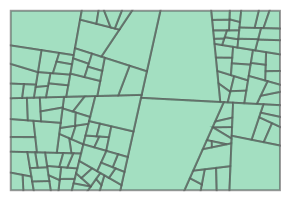

In [100]:
xgen = ss.uniform(loc=0.35, scale=0.25).rvs
split_func = functools.partial(gp.split_along_longest_side_of_min_rectangle, xgen=xgen)
splits = gp.recursive_split_frac_buffer(
    drawbox, 
    split_func=split_func,
    p_continue=0.8, 
    depth=0, 
    depth_limit=7,
    buffer_frac=-0.0
)

bps = MultiPolygon([p for p in splits])
bps


In [101]:
bg_bps_left = [bps]

In [102]:
bg_layers = []
for bg_bps in bg_bps_left:
    fills = []
    for p in bg_bps:
        xjitter_func = 0
        yjitter_func = ss.norm(loc=0, scale=np.random.uniform(0.15, 0.8)).rvs
        bhf = gp.BezierHatchFill(
            spacing=np.random.uniform(0.3, 0.45),
            degrees=np.random.uniform(10, 170),
            poly_to_fill=p, 
            xjitter_func=xjitter_func, 
            yjitter_func=yjitter_func,
            fill_inscribe_buffer=1.2,
            n_nodes_per_line=15,
            n_eval_points=40,
        )
        fills.append(bhf.p)

    fills = [f for f in fills if f.length > 0]
    layer = gp.merge_LineStrings(fills)
    bg_layers.append(layer)

In [103]:
sk = vsketch.Vsketch()
sk.size(paper.page_format_mm)
sk.scale('1mm')
sk.penWidth('0.3mm')
for i, layer in enumerate(bg_layers):
    sk.stroke(i+1)
    sk.geometry(layer)

sk.penWidth('0.3')
# for tolerance in [0.3, 0.6, 1.2]:
#     sk.vpype(f'linemerge --tolerance {tolerance}mm')
# sk.vpype('linesimplify --tolerance 0.1 linesort')
sk.display()

<?xml version="1.0" encoding="utf-8" ?>
 
 
 
 
 image/svg+xml 
 
 2021-10-14T20:56:34.738910 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <polyline points="833.5051,486.0826 832.8021,483.2968 831.8328,479.7939 830.8624,476.2906 829.9621,472.8131 829.1968,469.3853 828.6339,466.0321 828.3451,462.7798 828.4025,459.655 828.87,456.6812 829.793,453.8751 831.1889,451.2432 833.0401,448.779 835.2921,446.4623 837.8557,444.2604 840.6156,442.1308 843.4419,440.0256 846.2046,437.897 848.7896,435.703 851.1135,433.4128 853.1354,431.0114 854.8652,428.5024 856.3667,425.9094 857.7543,423.2744 859.1832,420.6547 860.8313,418.1156 862.8722,415.7212 863.2207,415.422"/>
 
 <polyline points="870.54,413.1138 868.2216,414.5451 865.6533,416.7453 863.6549,419.1554 862.0757,421.7198 860.7221,424.3673 859.3985,427.0258 857.9352,429.6329 856.2072,432.1425 854.1445,434.5289 851.735,436.7876 849.0217,438.9344 846.0937,441.0021 843.0736,443.0359 840.1016,445.0874 837.3192,447.2088 834.8534,449.4467 832.8032,451.8377 831.2316,454.4049 830.1619,457.1569 829.5797,460.0885 829.4404,463.1831 829.6788,466.4169 830.2207,469.7624 830.9922,473.1924 831.9247,476.6818 832.9534,480.2065 834.0074,483.7406 834.5728,485.753"/>
 <polyline points="836.6217,485.1204 836.4539,484.6415 835.1231,481.0055 833.831,477.3838 832.6564,473.8053 831.6703,470.2962 830.9464,466.8836 830.563,463.5965 830.5984,460.4636 831.1208,457.51 832.1767,454.7529 833.7803,452.1975 835.9051,449.834 838.4824,447.6371 841.4037,445.5669 844.53,443.5722 847.7052,441.5955 850.7729,439.5792 853.5939,437.4721 856.0635,435.2356 858.1262,432.8492 859.786,430.3145 861.1118,427.6567 862.2363,424.9249 863.348,422.1883 864.6744,419.5308 866.4542,417.0403 868.8957,414.7934 870.6844,413.7052"/>
 <polyline points="871.1506,415.6144 871.1429,415.6209 869.214,418.0566 867.814,420.6869 866.7251,423.4319 865.7171,426.2067 864.5821,428.9347 863.1569,431.5558 861.3358,434.0311 859.0761,436.3449 856.3977,438.5046 853.377,440.5382 850.1363,442.4908 846.8289,444.4188 843.6223,446.3839 840.68,448.4464 838.1446,450.6587 836.124,453.0605 834.6817,455.6754 833.8338,458.5091 833.5514,461.551 833.7682,464.7768 834.3927,468.1527 835.3204,471.6403 836.4458,475.2007 837.669,478.7971 838.8966,482.3951 839.4842,484.2366"/>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <polyline points="928.6295,456.7134 928.2727,456.9065 925.8397,458.311 923.4514,459.7741 921.1091,461.2973 918.8165,462.8853 916.5785,464.5448 914.4002,466.2823 912.285,468.1022 910.2333,470.0051 908.2419,471.9868 906.3028,474.0368 904.4035,476.1389 902.5279,478.2718 900.6567,480.4106 898.7702,482.5293 896.8497,484.6037 894.8807,486.6147 892.8549,488.5514 890.7725,490.4142 888.6431,492.2156 886.4863,493.981 884.329,495.7461 882.2029,497.5516 880.1371,499.4362 878.1508,501.4245 876.242,503.5141 874.7871,505.1855"/>
 <polyline points="875.0419,508.5224 875.8529,507.5897 877.6458,505.3486 879.4588,503.1338 881.3381,501.0055 88

In [185]:
# init
rcp = gp.RecursiveCirclePacker(
    drawbox, 
    rad_seq_start=0.6,
    rad_seq_end=0.07,
    min_allowed_rad=10,
    n_rads=20,
)
rcp.run(1)

100%|██████████| 4/4 [00:01<00:00,  2.30it/s]

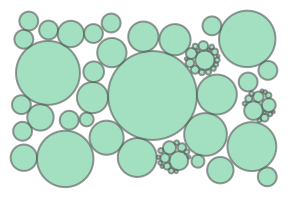

In [186]:
rcp.rad_seq_start=0.55
rcp.rad_seq_end=0.08
rcp.n_rads=80
rcp.run(4, progress_bar=True)
rcp.unfilled_circles

## lattice 1

100%|██████████| 4/4 [00:04<00:00,  1.11s/it]


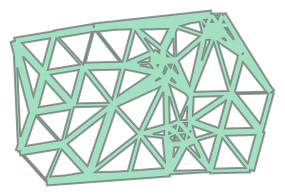

In [187]:
trcp = gp.RecursiveCirclePacker(drawbox.buffer(20), rad_seq_start=0.13,
    rad_seq_end=0.13, min_allowed_rad=3, n_rads=10, )
trcp.run(1)
trcp.min_allowed_rad=5
trcp.rad_seq_start=0.29
trcp.rad_seq_end=0.18
trcp.run(3)

length_filter_gen = ss.uniform(96, 185).rvs
buffer_size_gen = ss.uniform(0.8, 3.7).rvs
tri_vertices = MultiPoint([c.centroid for c in trcp.unfilled_circles])
trils = MultiLineString(so.triangulate(tri_vertices, edges=True))

filt_trils = MultiLineString([l for l in trils if l.length<length_filter_gen()])
tris = [f.buffer(buffer_size_gen(), cap_style=2, join_style=3) for f in filt_trils]
tris = so.unary_union(tris)
tris

In [188]:
occluded_tris = tris.intersection(rcp.unfilled_circles)

In [189]:
stp = gp.ScaleTransPrms(d_buffer=-0.2,angles=-45, d_translate_factor=0.75)
stp.d_buffers += np.random.uniform(-0.03, 0.03, size=stp.d_buffers.shape)

In [190]:
fills = []
for p in occluded_tris:
    P = gp.Poly(p)
    P.fill_scale_trans(**stp.prms)
    fills.append(P.fill)

In [191]:
layer1 = gp.merge_LineStrings(fills)

In [192]:
all_polys = occluded_tris

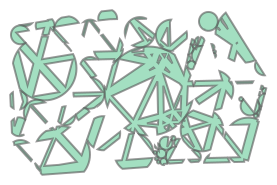

In [193]:
all_polys

## lattice 2

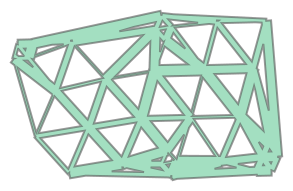

In [194]:
trcp = gp.RecursiveCirclePacker(drawbox.buffer(20), rad_seq_start=0.16,
    rad_seq_end=0.16, min_allowed_rad=2, n_rads=10, )
trcp.run(1)
trcp.min_allowed_rad=5
trcp.rad_seq_start=0.3
trcp.rad_seq_end=0.3
trcp.run(4)

length_filter_gen = ss.uniform(96, 185).rvs
buffer_size_gen = ss.uniform(1.1, 4.7).rvs
tri_vertices = MultiPoint([c.centroid for c in trcp.unfilled_circles])
trils = MultiLineString(so.triangulate(tri_vertices, edges=True))

filt_trils = MultiLineString([l for l in trils if l.length<length_filter_gen()])
tris = [f.buffer(buffer_size_gen(), cap_style=2, join_style=3) for f in filt_trils]
tris = so.unary_union(tris)
tris

In [195]:
int_tris = tris.intersection(rcp.unfilled_circles).buffer(0.8)

In [196]:
occluded_tris = gp.robust_difference(int_tris, all_polys, buffer_distance=-1e-6)

In [197]:
stp = gp.ScaleTransPrms(d_buffer=-0.25,angles=-45,d_translate_factor=0.65)
stp.d_buffers += np.random.uniform(-0.03, 0.03, size=stp.d_buffers.shape)

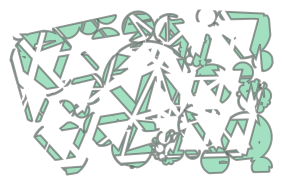

In [198]:
occluded_tris

In [199]:
fills = []
for p in occluded_tris:
    P = gp.Poly(p)
    P.fill_scale_trans(**stp.prms)
    fills.append(P.fill)

In [200]:
layer2 = gp.merge_LineStrings(fills)

In [201]:
all_polys = so.unary_union([all_polys, occluded_tris])

## lattice3

In [202]:
trcp = gp.RecursiveCirclePacker(drawbox.buffer(10), rad_seq_start=0.15,
    rad_seq_end=0.15, min_allowed_rad=2, n_rads=10, )
trcp.run(1)
trcp.min_allowed_rad=5
trcp.rad_seq_start=0.2
trcp.rad_seq_end=0.2
trcp.run(1)

In [203]:
length_filter_gen = ss.uniform(96, 185).rvs
buffer_size_gen = ss.uniform(0.4, 1.2).rvs
tri_vertices = MultiPoint([c.centroid for c in trcp.unfilled_circles])
trils = MultiLineString(so.triangulate(tri_vertices, edges=True))

filt_trils = MultiLineString([l for l in trils if l.length<length_filter_gen()])
tris = [f.buffer(buffer_size_gen(), cap_style=2, join_style=3) for f in filt_trils]
tris = so.unary_union(tris)

In [204]:
int_tris = tris.intersection(rcp.unfilled_circles).buffer(5.3)
occluded_tris = gp.robust_difference(int_tris, all_polys, buffer_distance=-1e-6)

In [205]:
stp = gp.ScaleTransPrms(d_buffer=-0.35,angles=-45,d_translate_factor=0.65)
stp.d_buffers += np.random.uniform(-0.03, 0.03, size=stp.d_buffers.shape)

In [206]:
fills = []
for p in occluded_tris:
    P = gp.Poly(p)
    P.fill_scale_trans(**stp.prms)
    fills.append(P.fill)

In [207]:
layer3 = gp.merge_LineStrings(fills)

In [208]:
all_polys = gp.merge_Polygons([all_polys, occluded_tris])

In [209]:
mbg = gp.merge_LineStrings([l for l in bg_layers[0] if l.length>0.05])

In [210]:
bg_layer = gp.robust_difference(mbg, all_polys.buffer(1e-6))

In [211]:
sk = vsketch.Vsketch()
sk.size(paper.page_format_mm)
sk.scale('1mm')
sk.penWidth('0.1mm')
sk.stroke(1)
sk.geometry(bg_layer)
sk.stroke(2)
sk.geometry(layer1)
sk.stroke(3)
sk.geometry(layer2)
sk.stroke(4)
sk.geometry(layer3)
sk.penWidth('0.1')

tolerance=0.1
sk.vpype(f'linesimplify --tolerance {tolerance}')
for tolerance in [0.1, 0.2, 0.4]:
    sk.vpype(f'linemerge --tolerance {tolerance}mm')
sk.vpype('linesort')
sk.display(color_mode='none')

<?xml version="1.0" encoding="utf-8" ?>
 
 
 
 
 image/svg+xml 
 
 2021-10-14T21:04:34.184659 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <polyline points="869.1441,494.3871 859.0838,478.1853 859.603,478.025 859.3563,476.7808 860.3233,477.8026 870.0661,493.7593 871.1543,493.047 864.6216,482.2017 861.5545,477.4225 861.6417,477.3956 861.4756,476.5012 862.3583,477.1744 871.8556,492.6267 873.0433,491.9148 863.5362,476.8107 863.4363,476.8415 863.2577,476.0864 863.8773,475.9007 864.0601,476.6489 864.4926,476.5154 873.6586,490.4061 873.6806,490.6935 879.6856,485.0942 883.6762,481.1411 896.7204,466.5652 896.1481,466.7419 892.9367,461.8828 881.6581,447.7968 878.1709,442.8066"/>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <polyline points="915.6442,446.2432 913.3119,442.8388 903.6468,430.7637 899.8888,424.8597 900.5295,424.8446 902.7228,428.3139 904.2352,430.3892 914.2853,442.2192 917.1005,446.2789 918.4172,446.3113 916.7585,443.6829 915.228,441.6192 905.1209,429.8254 901.6954,424.7278 902.5548,424.6241 905.7954,429.3961 909.1091,433.3626 916.109,441.0585 917.7244,443.0681 919.9435,446.3487 921.3634,446.3836 920.1882,444.5378 917.0119,440.4839 908.3188,430.8278 905.2902,426.6798 903.8705,424.3484 905.2099,423.9883 907.9289,428.0381 909.5387,430.0513 916.6488,437.6772 920.0498,441.5881 921.5637,443.6623 923.2049,446.4288"/>
 
 <polyline points="928.6252,446.5619 927.0126,443.232 925.6225,441.079 924.0519,439.0408 920.5043,435.2232 912.9505,427.8799 911.1911,425.9619 908.5361,422.6362 909.7193,421.981 912.2204,425.3067 913.9216,427.2618 921.328,434.6989 924.8647,438.5235 926.4458,440.555 927.8567,442.6948 929.7728,446.59 931.0144,446.6205 930.0201,444.3556 928.7842,442.1044 925.7722,437.9459 914.9298,426.6201 913.2725,424.6371 910.8313,421.2375 911.9674,420.3801 914.6065,423.788 916.3348,425.7258 923.7354,433.1667 927.205,437.034 930.1329,441.246 931.3403,443.5153 932.642,446.6605"/>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <polyline points="965.3012,488.0398 965.9875,487.7423 965.9875,487.7423 971.3298,485.3756 971.3298,485.3756 965.2152,487.6604 965.2928,488.0028 965.9875,487.7423 965.9875,487.7423 973.7354,485.0666 980.2655,483.5131 980.3385,484.2246 979.2782,484.4226 979.2782,484.4226 980.3363,484.2098 980.3516,484.3128 974.1908,485.9003 971.5341,486.8126 965.5616,489.2436 965.7401,490.6471 969.4835,488.8346 974.6669,486.7719 980.4921,485.2598 979.2782,484.4226 974.0479,485.6386 970.9637,486.6037 970.9637,486.6037 974.0598,485.6605 979.2782,484.4226"/>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <polyline points="1013.4203,487.8984 1007.1368,480.688 1002.7646,474.4952 1002.7688,474.6283 1000.7373,476.7386 999.6658,477.5949 999.3815,478.0485 1000.9063,477.048 1002.7939,475.4124 1002.8054,475.7717 1001.1312,477.4598 998.6143,479.2726 998.5985,479.2979 1001.1431,477.4815 1002.808,475.8533 1002.8487,477.1277 1001.7196,478.5368 999.6244,480.4771 998.5116,481.2332 998.5116,481.2332 996.6786,482.3612 996.9435,481.9386 998.5116,481.2332 998.5116,481.2332 999.7233,480.6581 1001.2482,479.6359 1001.2482,479.6359 999.8269,480.8477 996.127,483.2414 995.7644,483.82 997.6893,482.7104 999.9445,481.063 1002.2239,478.9322 1002.2239,478.9322 1002.8867,478.3157"/>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <polyline points="1044.0472,441.8417 1047.2846,445.6343 1050.1604,449.5485 1058.2677,461.8914 1058.2677,461.5525 1054.2838,455.5326 1049.231,447.2898 1045.197,441.5196 1045.502,441.4342 1041.2019,441.0833 1038.2494,440.5783 1035.4347,439.7072 1032.7808,438.4086 1030.2863,436.686 1027.9295,434.5973 1025.6738,432.2398 1019.0778,424.7121 1015.4008,421.0592 1015.4008,421.0592 1019.3404,424.0139 1028.9419,432.3926 1028.9419,432.3926 1019.5239,423.5259 1014.9809,419.9864 1015.4008,421.0592 1014.6276,420.3396 1014.5233,420.444 1015.4008,421.0592"/>
 <polyline points="1015.96,418.8958 1020.0062,422.2434 1022.3003,424.499 1029.0226,431.6908 1031.3483,433.8621 1032.7153,434.909 1032.7153,434.909 103

In [218]:
import fn
from pathlib import Path

In [215]:
plot_id = fn.new_plot_id()

saved 20211014-210510_599988-b365a-a36aca to s3://algorithmic-ink/current_plot_id


In [216]:
savedir='/home/naka/art/plotter_svgs'

In [219]:
savepath = Path(savedir).joinpath(f'{plot_id}.svg').as_posix()
sk.save(savepath)